# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs.git

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

### Laplace Equation
$\begin{equation}
u_{xx} + u_{yy} = 0, \quad \text{for} (x,y) \in [0,5] \times [0.3],
\end{equation}$
and the boundary conditions
$u(x = 0, y) = u(x = 5, y) = u(x, y = 0) = 0, u(x, y = 3) = 2$.


In [15]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import pandas as pd

np.random.seed(1234)

In [16]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [17]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [18]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([5.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_xx + lambda_1* u_tt
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
    
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Training on Non-noisy Data

In [19]:
data = pd.read_excel('laplace_data.xlsx')

In [20]:
T = np.array(data['Y']).flatten()[:,None]
X = np.array(data['X']).flatten()[:,None]
Exact = np.array(data['u_pred']).flatten()[:,None]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

N_u = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)  
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

It: 0, Loss: 8.607e-01, Lambda_1: 4.999
It: 100, Loss: 1.854e-01, Lambda_1: 4.870
It: 200, Loss: 3.939e-02, Lambda_1: 4.806
It: 300, Loss: 3.093e-02, Lambda_1: 4.782
It: 400, Loss: 2.649e-02, Lambda_1: 4.757
It: 500, Loss: 2.393e-02, Lambda_1: 4.729
It: 600, Loss: 2.240e-02, Lambda_1: 4.699
It: 700, Loss: 2.182e-02, Lambda_1: 4.666
It: 800, Loss: 1.902e-02, Lambda_1: 4.633
It: 900, Loss: 1.810e-02, Lambda_1: 4.596
It: 1000, Loss: 1.744e-02, Lambda_1: 4.556
It: 1100, Loss: 1.638e-02, Lambda_1: 4.520
It: 1200, Loss: 1.604e-02, Lambda_1: 4.477
It: 1300, Loss: 5.728e-02, Lambda_1: 4.438
It: 1400, Loss: 1.504e-02, Lambda_1: 4.394
It: 1500, Loss: 1.431e-02, Lambda_1: 4.354
It: 1600, Loss: 1.435e-02, Lambda_1: 4.307
It: 1700, Loss: 1.369e-02, Lambda_1: 4.266
It: 1800, Loss: 1.486e-02, Lambda_1: 4.217
It: 1900, Loss: 1.323e-02, Lambda_1: 4.175
It: 2000, Loss: 1.271e-02, Lambda_1: 4.134
It: 2100, Loss: 1.299e-02, Lambda_1: 4.083
It: 2200, Loss: 1.232e-02, Lambda_1: 4.042
It: 2300, Loss: 1.189e-

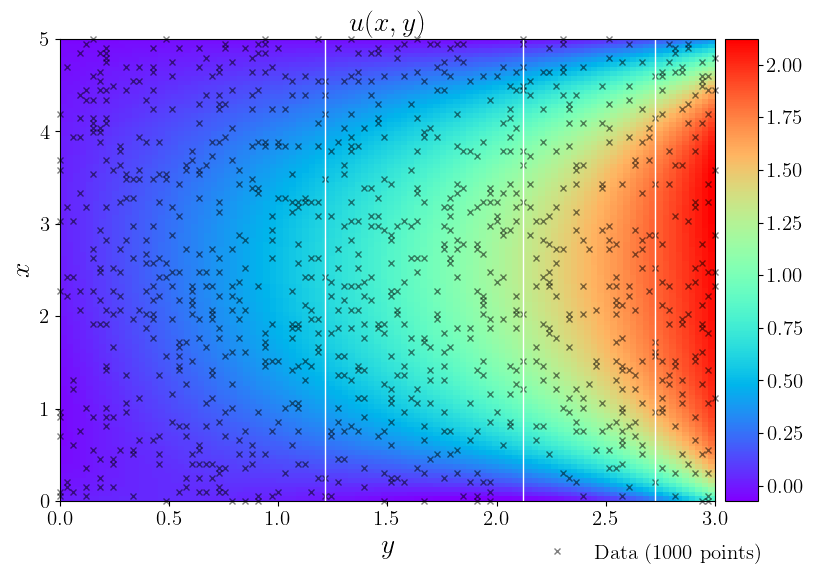

In [28]:
####### Row 0: u(t,x) ##################    
x = np.linspace(0,5,100)
t = np.linspace(0,3,100)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[70]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[90]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$y$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.savefig("laplace_inverse.pdf", format="pdf")

plt.show()

In [22]:
Exact = Exact.reshape(100,100)
U_pred = U_pred.reshape(100,100)

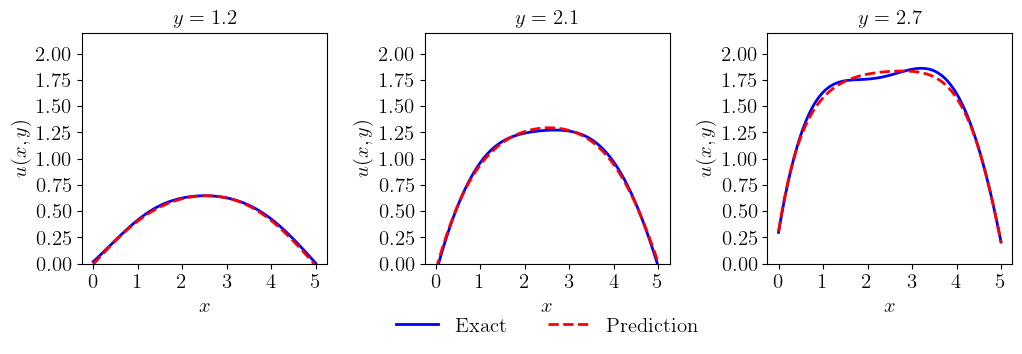

In [23]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(12, 3))
#ax = fig.add_subplot(111)
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.4)

plot1 = plt.subplot(gs[0, 0])
plot1.plot(x,Exact[40,:], 'b-', linewidth = 2, label = 'Exact')       
plot1.plot(x,U_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
plot1.set_xlabel('$x$')
plot1.set_ylabel('$u(x,y)$')    
plot1.set_title('$y = 1.2$', fontsize = 15)
#plot1.axis('square')
#ax.set_xlim([-1.1,1.1])
plot1.set_ylim([0,2.2])  

for item in ([plot1.title, plot1.xaxis.label, plot1.yaxis.label] +
             plot1.get_xticklabels() + plot1.get_yticklabels()):
    item.set_fontsize(15)

plot2 = plt.subplot(gs[0, 1])
plot2.plot(x,Exact[70,:], 'b-', linewidth = 2, label = 'Exact')       
plot2.plot(x,U_pred[70,:], 'r--', linewidth = 2, label = 'Prediction')
plot2.set_xlabel('$x$')
plot2.set_ylabel('$u(x,y)$')
#plot2.axis('square')
#ax.set_xlim([-1.1,1.1])
plot2.set_ylim([0,2.2])  
plot2.set_title('$y = 2.1$', fontsize = 15)
plot2.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([plot2.title, plot2.xaxis.label, plot2.yaxis.label] +
             plot2.get_xticklabels() + plot2.get_yticklabels()):
    item.set_fontsize(15)

plot3 = plt.subplot(gs[0, 2])
plot3.plot(x,Exact[90,:], 'b-', linewidth = 2, label = 'Exact')       
plot3.plot(x,U_pred[90,:], 'r--', linewidth = 2, label = 'Prediction')
plot3.set_xlabel('$x$')
plot3.set_ylabel('$u(x,y)$')
#plot3.axis('square')
#ax.set_xlim([-1.1,1.1])
plot3.set_ylim([0,2.2])    
plot3.set_title('$y = 2.7$', fontsize = 15)

for item in ([plot3.title, plot3.xaxis.label, plot3.yaxis.label] +
             plot3.get_xticklabels() + plot3.get_yticklabels()):
    item.set_fontsize(15)


plt.savefig("laplace_inverse_t.pdf", format="pdf")

plt.show()

In [24]:
lambda_1_value = model.lambda_1.detach().cpu().numpy()
error_lambda_1 = np.abs(lambda_1_value - 1.0)/1.0 * 100
print('Error l1: %.5f%%' % (error_lambda_1))    

Error l1: 0.16513%


## Training on Noisy Data

In [25]:
noise = 0.01    

# create training set
u_train_noise = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

model = PhysicsInformedNN(X_u_train, u_train_noise, layers, lb, ub)
model.train(10000)

It: 0, Loss: 1.140e+00, Lambda_1: 4.999
It: 100, Loss: 2.862e-01, Lambda_1: 4.864
It: 200, Loss: 4.709e-02, Lambda_1: 4.729
It: 300, Loss: 2.881e-02, Lambda_1: 4.706
It: 400, Loss: 2.651e-02, Lambda_1: 4.686
It: 500, Loss: 2.268e-02, Lambda_1: 4.657
It: 600, Loss: 2.101e-02, Lambda_1: 4.620
It: 700, Loss: 1.958e-02, Lambda_1: 4.578
It: 800, Loss: 1.852e-02, Lambda_1: 4.531
It: 900, Loss: 1.692e-02, Lambda_1: 4.484
It: 1000, Loss: 1.597e-02, Lambda_1: 4.432
It: 1100, Loss: 1.630e-02, Lambda_1: 4.380
It: 1200, Loss: 1.401e-02, Lambda_1: 4.329
It: 1300, Loss: 1.321e-02, Lambda_1: 4.275
It: 1400, Loss: 1.245e-02, Lambda_1: 4.219
It: 1500, Loss: 1.231e-02, Lambda_1: 4.164
It: 1600, Loss: 1.469e-02, Lambda_1: 4.109
It: 1700, Loss: 1.046e-02, Lambda_1: 4.052
It: 1800, Loss: 9.978e-03, Lambda_1: 3.993
It: 1900, Loss: 9.862e-03, Lambda_1: 3.937
It: 2000, Loss: 9.212e-03, Lambda_1: 3.879
It: 2100, Loss: 9.060e-03, Lambda_1: 3.819
It: 2200, Loss: 8.633e-03, Lambda_1: 3.763
It: 2300, Loss: 8.404e-

In [26]:
lambda_1_value_noise = model.lambda_1.detach().cpu().numpy()
error_lambda_1_noise = np.abs(lambda_1_value_noise - 1.0)/1.0 * 100
print('Error l1: %.5f%%' % (error_lambda_1_noise))

Error l1: 2.06748%


### Identified PDE

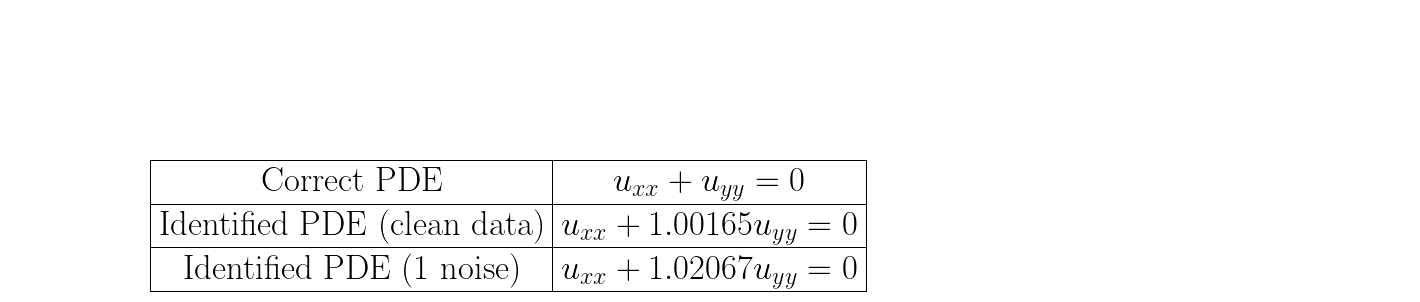

In [27]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_{xx} + u_{yy} = 0$ \\ '
s2 = r'\hline Identified PDE (clean data) & $u_{xx} + %.5f u_{yy} = 0$ \\' % (lambda_1_value)
s3 = r'\hline Identified PDE (1 noise) & $u_{xx} + %.5f u_{yy} = 0$ \\' % (lambda_1_value_noise)
s4 = r'\hline \end{tabular}$'
s = s1+s2+s3+s4
ax.text(0.1, 0.1, s, size=25)

plt.show()